##Dowmload the dataset
首先先下載本次作業所需要用到的資料，解壓縮後資料夾內的結構如下
```
data/
|----train_50
    |----0_0.png
    |----0_1.png
    ...
|----val_50
    |----0_450.png
    |----0_451.png
    ...
|----val_gt.csv
```
資料集是Imagenet的一小部分，是很多模型用來測試其效果的資料集，原本Imagenet有1000個分類，但這次作業只會取其中50個類別來分類，另外這次作業分為train_set和validation_set，同學需要透過train_set訓練模型，再來透過validation_set驗證圖片的第一個數字代表他所屬的class

**注意!!!
在做模型的訓練時只可以用train_set的資料，不可以用到validation_set的資料，被發現的話以零分處理**


In [1]:
!gdown --id 1JI_LGAJADDOPfEPeOW7_3NiBYMvJ6n4J --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1JI_LGAJADDOPfEPeOW7_3NiBYMvJ6n4J
To: /content/data.zip
66.3MB [00:02, 29.9MB/s]


##Mount Google Drive(Optional)
由於Colab會有長期沒有使用的話自動斷線的可能性，因此可以掛載google雲端硬碟，並週期性的將模型儲存在雲端硬碟中


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

##Import the package

In [2]:
import os
import glob
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import tensorflow as tf

由於訓練過程中會有一些隨機性，為了確保每次重新訓練的情況下都可以得到同樣的結果，因此將random、torch、numpy三個套件的 random seed固定

In [3]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

##Dataset
TODO

可以參考之前提供的sample code 完成客製化的Dataset class完成客製化的Dataset class

In [4]:
class IMAGE(Dataset):
  def __init__(self,root,transform=None):
    self.transform = transform
    self.filenames = []
    filenames = glob.glob(os.path.join(root,'*.png'))
    # print(filenames)
    for fn in filenames:
        if root == 'data/train_50':
          i = fn[14:]
          if i[1] == '_':
            i = i[:1]
          elif i[2] == '_':
            i = i[:2]
          elif i[3] == '_':
            i = i[:3]
        if root == 'data/val_50':
          i = fn[12:]
          if i[1] == '_':
            i = i[:1]
          elif i[2] == '_':
            i = i[:2]
          elif i[3] == '_':
            i = i[:3]
        i = int(i)
        self.filenames.append((fn,i))
    self.len = len(self.filenames)

  def __getitem__(self,index):
    image_fn,label = self.filenames[index]
    image = Image.open(image_fn)
    if self.transform is not None:
      image = self.transform(image)
    return image,label
  def __len__(self):
    return self.len

In [5]:
transform_set = [ 
  transforms.RandomResizedCrop(142, scale=(0.2, 1.0), ratio=(0.9, 1.1)), 
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(60)
]
train_tfm = transforms.Compose([
	transforms.Resize((142, 142)),
  # transforms.RandomHorizontalFlip(),
  # transforms.RandomRotation(15),
  transforms.RandomApply(transform_set, p=0.75),
	# transforms.RandomCrop(128),
	transforms.ToTensor(),
])


test_tfm = transforms.Compose([
    transforms.Resize((142, 142)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
])

In [6]:
trainset = IMAGE(root='data/train_50',transform=train_tfm)
validationset = IMAGE(root='data/val_50',transform=test_tfm)

print('# images in trainset:', len(trainset)) 
print('# images in validationset:', len(validationset))

# images in trainset: 22500
# images in validationset: 2500


In [7]:
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
validationset_loader = DataLoader(validationset, batch_size=1000, shuffle=False, num_workers=1)

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# labels = np.asarray(labels)
# labels = tf.convert_to_tensor(labels)

print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

Image tensor in each batch: torch.Size([64, 3, 142, 142]) torch.float32
Label tensor in each batch: torch.Size([64]) torch.int64


Labels:
tensor(30) tensor(42) tensor(7) tensor(24) tensor(0) tensor(28) tensor(42) tensor(16) tensor(41) tensor(18) tensor(25) tensor(18) tensor(35) tensor(40) tensor(30) tensor(16)


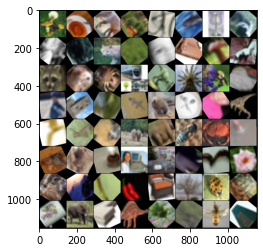

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(16)))

##MODEL
這次的作業不會一定要同學重頭開始訓練，pytorch有內建在不同種資料集訓練的模型，有各種不同的方式可以載入預訓練好的模型，以下提供一個方法給同學，但需要注意的是同學最好還是要了解一下使用的模型架構，像是以Imagenet訓練的模型最後會輸出1000個值，但是這次的小資料集只需要分成50個類別，因此可能就需要做一些調整
```
import torchvision.models as models 
model = models.vgg16(pretrained=True)
```

In [9]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

!nvidia-smi

Device used: cuda
Fri Jun 25 12:12:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                      

In [10]:
import torchvision.models as models 
model = models.densenet121(pretrained=True).to(device)
numFit = model.classifier.in_features
model.classifier = nn.Linear(numFit, 50).to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [11]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# PCA

In [18]:
# 輸出densenet121倒數第二層(denselayer15的conv2d層)
# ref:https://blog.csdn.net/Hungryof/article/details/80921417
# ref:https://zhuanlan.zhihu.com/p/362985275
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.features.denseblock4.denselayer16.conv2.register_forward_hook(get_activation('features.denseblock4.denselayer15.conv2'))
x = torch.randn(64, 3, 224, 224).to(device)
output = model(x)
print(activation['features.denseblock4.denselayer15.conv2'])

tensor([[[[-7.3949e-03, -1.4578e-02, -1.5900e-02,  ..., -1.4268e-02,
           -1.4192e-02, -1.2467e-02],
          [-7.1420e-03, -1.4429e-02, -1.5954e-02,  ..., -1.4402e-02,
           -1.4771e-02, -1.3884e-02],
          [-7.2925e-03, -1.5190e-02, -1.5441e-02,  ..., -1.3514e-02,
           -1.4771e-02, -1.4318e-02],
          ...,
          [-6.9471e-03, -1.4213e-02, -1.4634e-02,  ..., -1.4003e-02,
           -1.6103e-02, -1.6075e-02],
          [-8.8510e-03, -1.4336e-02, -1.2771e-02,  ..., -1.2764e-02,
           -1.2165e-02, -1.4291e-02],
          [-2.9687e-03, -5.2331e-03, -3.6425e-03,  ..., -3.3138e-03,
           -3.6459e-03, -5.2766e-03]],

         [[-1.1582e-02, -1.4468e-02, -1.2818e-02,  ..., -1.1649e-02,
           -1.1030e-02, -6.3641e-03],
          [-1.7886e-02, -2.0919e-02, -1.7740e-02,  ..., -1.6880e-02,
           -1.5919e-02, -8.7235e-03],
          [-1.4664e-02, -1.7246e-02, -1.5538e-02,  ..., -1.6039e-02,
           -1.5646e-02, -8.2096e-03],
          ...,
     

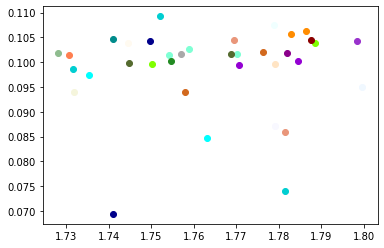

In [32]:
# PCA降維
# ref: https://blog.csdn.net/zjh12312311/article/details/114307369

# 設置顏色 總共50個label
color = ['aliceblue','antiquewhite','aqua','aquamarine','azure','beige','bisque','black','blanchedalmond','blue',
      'blueviolet','brown','burlywood','cadetblue','chartreuse','chocolate','coral','cornflowerblue','cornsilk','crimson',
      'cyan','darkblue','darkcyan','darkgoldenrod','darkgray','darkgreen','darkkhaki','darkmagenta','darkolivegreen','darkorange',
      'darkorchid','darkred','darksalmon','darkseagreen','darkslateblue','darkslategray','darkturquoise','darkviolet','deeppink','deepskyblue',
      'dimgray','dodgerblue','firebrick','floralwhite','forestgreen','fuchsia','gainsboro','ghostwhite','gold','goldenrod']
# 繪圖
def show(v2,y):
    for i in range(len(v2)):
        plt.scatter(v2[i][0],v2[i][1],color=color[y[i]])
    plt.show()

# for (x,y) in activation['features.denseblock4.denselayer15.conv2'].cpu():
for (x,y) in trainset_loader:
    # print(y)
    x = activation['features.denseblock4.denselayer15.conv2'].cpu() #取得model輸出 [64, 3, 7, 7]
    x = x.flatten(start_dim=2,end_dim=-1) #tensor壓縮 [64, 3, 49]
    # print(x.shape)
    v2 = []
    # print(len(x))
    for i in range(len(x)):
        v2.append(torch.pca_lowrank(x[i],q=2)[1].numpy()) # 2维PCA
show(v2,y)

##t-SNE

In [ ]:
#TSNE降維
import numpy as np
from sklearn.manifold import TSNE
x = activation['features.denseblock4.denselayer15.conv2'].cpu() #取得model輸出 [64, 3, 7, 7]
x = x.flatten(start_dim=2,end_dim=-1) #tensor壓縮 [64, 3, 49]
x = x.flatten(start_dim=1,end_dim=-1) #tensor壓縮 [64, 147]
X = np.array(x)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(64, 2)

In [65]:
#TSNE降維
# ref: https://towardsdatascience.com/t-sne-python-example-1ded9953f26
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

for (X,y) in trainset_loader:
    # X = activation['features.denseblock4.denselayer15.conv2'].cpu() #取得model輸出 [64, 3, 7, 7]
    X = X.flatten(start_dim=2,end_dim=-1) #tensor壓縮 [64, 3, 49]
    X = X.flatten(start_dim=1,end_dim=-1) #tensor壓縮 [64, 147]
    # X = torch.split(X, 36)[0]
    # X, y = load_digits(return_X_y=True)

MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

def _gradient_descent(obj_func, p0, args, it=0, n_iter=400,
                      n_iter_check=1, n_iter_without_progress=1000,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

[t-SNE] Iteration 1: error = 0.2521593, gradient norm = 0.0000368
[t-SNE] Iteration 2: error = 0.2521606, gradient norm = 0.0005786
[t-SNE] Iteration 3: error = 0.2523764, gradient norm = 0.0072649
[t-SNE] Iteration 4: error = 0.2707369, gradient norm = 0.0605390
[t-SNE] Iteration 5: error = 0.5023191, gradient norm = 0.0897355
[t-SNE] Iteration 6: error = 0.5507083, gradient norm = 0.0775252
[t-SNE] Iteration 7: error = 0.4906468, gradient norm = 0.0910283
[t-SNE] Iteration 8: error = 0.7406451, gradient norm = 0.0921153
[t-SNE] Iteration 9: error = 0.8027722, gradient norm = 0.1036542
[t-SNE] Iteration 10: error = 0.7600850, gradient norm = 0.1032239
[t-SNE] Iteration 11: error = 0.8785635, gradient norm = 0.1182819
[t-SNE] Iteration 12: error = 0.8424138, gradient norm = 0.0868626
[t-SNE] Iteration 13: error = 0.7732171, gradient norm = 0.0457672
[t-SNE] Iteration 14: error = 0.7517905, gradient norm = 0.0374220
[t-SNE] Iteration 15: error = 0.7446560, gradient norm = 0.0439872
[t-S

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


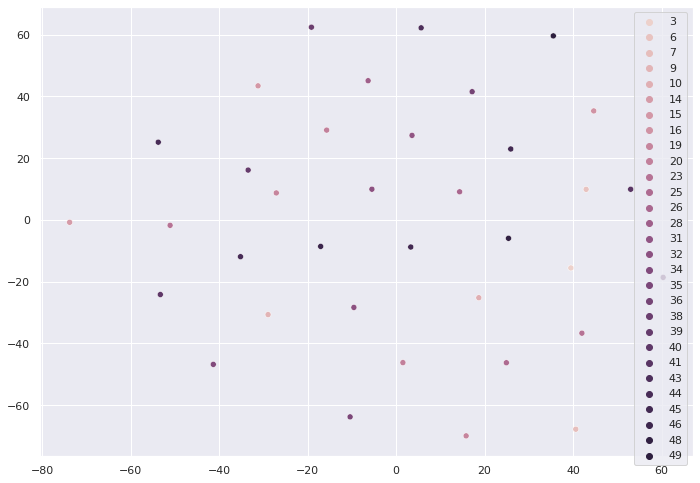

In [66]:
X_embedded = fit(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')

##Training function

In [12]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

def train_save(model, epoch, save_interval, log_interval=100):
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    iteration = 0
    for ep in range(epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('model%i.pth' % iteration, model, optimizer)
            iteration += 1
        validate(model)
    save_checkpoint('model%i.pth' % iteration, model, optimizer)

##Validation

In [13]:
def validate(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validationset_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(validationset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(validationset_loader.dataset),
        100. * correct / len(validationset_loader.dataset)))

##Start Training

In [14]:
# Start training the model
train_save(model,10,500,100)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/22500 (0%)]	Loss: 4.208523
Train Epoch: 0 [6400/22500 (28%)]	Loss: 2.276989
Train Epoch: 0 [12800/22500 (57%)]	Loss: 1.832035
Train Epoch: 0 [19200/22500 (85%)]	Loss: 1.650978

Test set: Average loss: 0.0011, Accuracy: 1882/2500 (75%)

Train Epoch: 1 [3072/22500 (14%)]	Loss: 1.372110
Train Epoch: 1 [9472/22500 (42%)]	Loss: 0.951711
model saved to model500.pth
Train Epoch: 1 [15872/22500 (70%)]	Loss: 1.137278
Train Epoch: 1 [22272/22500 (99%)]	Loss: 1.209562

Test set: Average loss: 0.0008, Accuracy: 1999/2500 (80%)

Train Epoch: 2 [6144/22500 (27%)]	Loss: 0.834778
Train Epoch: 2 [12544/22500 (56%)]	Loss: 0.742708
Train Epoch: 2 [18944/22500 (84%)]	Loss: 0.900583
model saved to model1000.pth

Test set: Average loss: 0.0007, Accuracy: 2037/2500 (81%)

Train Epoch: 3 [2816/22500 (12%)]	Loss: 0.793379
Train Epoch: 3 [9216/22500 (41%)]	Loss: 0.783650
Train Epoch: 3 [15616/22500 (69%)]	Loss: 1.305259
Train Epoch: 3 [22016/22500 (98%)]	Loss: 0.590972

Test set: Average loss:

##Load Model

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# load from the final checkpoint
load_checkpoint('model3520.pth', model, optimizer)


model loaded from model3520.pth


##Prediction

In [16]:
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the filename from validaiton set.
filename_list = []
path = 'data/val_50'
for infile in glob.glob(os.path.join(path, '*.png')):
  filename_list.append(infile[12:])

# Initialize a list to store the predictions.
predictions = []
# Iterate the validation set by batches.
for batch in validationset_loader:
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [17]:
# Save predictions into the file.
with open("test_pred.csv", "w") as f:

    # The first row must be "image_id, label"
    f.write("image_id,label\n")

    # For the rest of the rows, each image corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{filename_list[i]},{pred}\n")